# Training a model on CarbonTracker's carbon flux
This notebook outlines the entire workflow to load and preprocess the following data sets, to be able to train a ML model:

- CarbonTracker
- ERA5 (monthly)
- ERA5-land (monthly)
- SPEI (monthly)
- MODIS (monthly)
- Land-cover (annually)

First download the data using the instructions in the README file.

The functions written to process the data are contained in `src`. We can import them with:

In [2]:
from src import carbontracker
from src import spei
from src import utils
from src import modis
from pathlib import Path
import xarray as xr
import xarray_regrid  # Importing this will make Dataset.regrid accessible.

We will load the CarbonTracker data into an xarray `Dataset` and convert the timestamps (middle point of each month) to a more standard format (1st day of the month), to allow merging with ERA5 data.

In [3]:
ds_cb = xr.open_dataset("/data/volume_2/EXCITED_prepped_data/CT2022.flux1x1-monthly.nc")
ds_cb = utils.convert_timestamps(ds_cb)

/home/yangliu/venv/excited/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


Next we load in the monthly ERA5 data. We will have to convert the longitude values to be formatted (-180 -> 180 degrees) instead of (0 -> 360 degrees).

Next we coarsen the data to a 1-degree grid, centered around the half values (e.g., [0.5, 1.5, ...]).

In [4]:
ds_era5 = xr.open_mfdataset("/data/volume_2/monthly_era5/*.nc")
ds_era5 = carbontracker.shift_era5_longitude(ds_era5)
ds_era5 = carbontracker.coarsen_era5(ds_era5)

Similar to ERA5 data, we can add ERA5 land data. <br>
Since the grid for ERA5 land data is 0.1x0.1 deg lat/lon, we could use the nearest neighbour method for regridding.

In [5]:
ds_era5_land = xr.open_mfdataset("/data/volume_2/monthly_era5-land/*.nc")
ds_era5_land = carbontracker.shift_era5_longitude(ds_era5_land)
ds_era5_land_regrid = ds_era5_land.regrid.regrid(ds_era5, method="nearest")
ds_era5_land_regrid

<xarray.Dataset>
Dimensions:    (time: 252, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-12-01
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    stl1       (time, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    stl2       (time, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    stl3       (time, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    stl4       (time, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    swvl4      (time, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-28 15:08:17 UTC by era5cli 1.4.1: reanalysis-era5-l...

Let's add SPEI dataset to our recipe. <br>
It is also needed to convert the timestamps to a more standard format.

In [10]:
ds_spei = spei.load_spei_data("/data/volume_2/spei/spei06.nc").sel(time=slice("2000-01", "2020-12"))
# regrid spei dataset to desired era5 grid
ds_spei_regrid = ds_spei.regrid.regrid(ds_era5, method="linear")
ds_spei_regrid

/home/yangliu/venv/excited/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:    (time: 252, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-12-01
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    spei       (time, latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes: (12/14)
    Title:        Global 6-months SPEI, z-values, 0.5 degree
    Version:      2.6
    Id:           ./outputNcdf/spei06.nc
    Summary:      Global dataset of the Standardized\n\t  Precipitation-Evapo...
    Keywords:     drought, climatology, SPEI, Standardized\n\t  Precipitation...
    Institution:  Consejo Superior de Investigaciones\n\t          Científica...
    ...           ...
    Software:     Created in R using the SPEI package\n\t          (https://c...
    Call:         spei.nc(sca=i, inPre=./inputData/cru_ts4.06.1901.2021.pre.d...
    Date:         Wed Feb  1 12:38:25 2023
    Reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    Reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    Reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...

Now we also include variables (e.g. NIRv) from MODIS dataset.

In [8]:
ds_modis = modis.load_modis_data("/data/volume_2/modis_nirv_v2")
# regrid modis dataset to era5 grid
ds_modis_regrid = ds_modis.regrid.regrid(ds_era5, method="linear")
ds_modis_regrid

<xarray.Dataset>
Dimensions:    (time: 274, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 2000-03-01 2000-04-01 ... 2022-12-01
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    NDVI       (time, latitude, longitude) float32 dask.array<chunksize=(274, 180, 360), meta=np.ndarray>
    NIRv       (time, latitude, longitude) float32 dask.array<chunksize=(274, 180, 360), meta=np.ndarray>
Attributes:
    author:         Gerbrand Koren (gerbrand.koren@wur.nl)
    creation_date:  2020-02-21 22:01:20
    version:        v0.1

To limit the analyis to Transcom region 2 (North America) we require the `regions.nc` file:

In [9]:
ds_regions = xr.open_dataset("/data/volume_2/EXCITED_prepped_data/regions.nc")
# Uncomment the next line to preview the region:
#ds_regions["transcom_regions"].where(ds_regions["transcom_regions"]==2).plot()

Now we can merge all three datasets together. From the CarbonTracker file we only require the `bio_flux_opt` variable:

In [11]:
ds_merged = xr.merge([ds_cb[["bio_flux_opt"]], ds_regions["transcom_regions"],
                      ds_era5, ds_modis_regrid["NIRv"], ds_spei_regrid, ds_era5_land_regrid])

To make computations faster and less memory intensive, we can reduce the scope to only North America.

This `.sel` operation reduces the size of the dataset from worldwide to only a rectangular area around North America:

In [12]:
time_region_na = {
    "time": slice("2010-01", "2019-12"),
    "latitude": slice(15, 60),
    "longitude": slice(-140, -55),
}
ds_na = ds_merged.sel(time_region_na)

In [13]:
ds_na

<xarray.Dataset>
Dimensions:           (longitude: 85, latitude: 45, time: 120)
Coordinates:
  * longitude         (longitude) float64 -139.5 -138.5 -137.5 ... -56.5 -55.5
  * latitude          (latitude) float64 15.5 16.5 17.5 18.5 ... 57.5 58.5 59.5
  * time              (time) datetime64[ns] 2011-01-01 2011-02-01 ... 2020-12-01
Data variables: (12/23)
    bio_flux_opt      (time, latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    transcom_regions  (latitude, longitude) float64 ...
    d2m               (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    mslhf             (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    msshf             (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    sp                (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    ...                ...
    stl3              (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    stl4              (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    swvl1             (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    swvl2             (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    swvl3             (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
    swvl4             (time, latitude, longitude) float32 dask.array<chunksize=(12, 45, 85), meta=np.ndarray>
Attributes:
    averaging_period_length_hours:  744
    email:                          carbontracker.team@noaa.gov
    url:                            http://carbontracker.noaa.gov
    institution:                    NOAA Earth System Research Laboratory
    Conventions:                    CF-1.5
    history:                        Time-stamp: <Orion-login-1.HPC.MsState.Ed...
    NCO:                            netCDF Operators version 4.9.3 (Homepage ...
    version:                        CT2022 1x1 3-hourly fluxes as of 2023-01-...

We can now compute the dataset (instead of leaving it lazy and out-of-memory), as it is small enough to fit into RAM.
This operation should not take more than 1 or 2 minutes.

In [14]:
ds_na = ds_na.compute()

From this North American dataset we can mask the transcom region, and preview the 2m air temperature of ERA5:

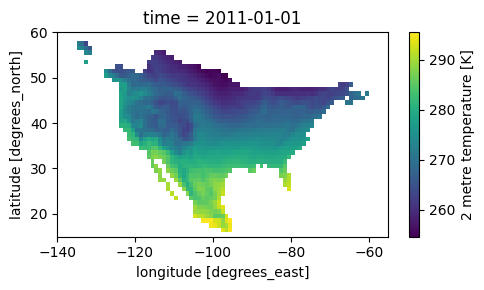

In [15]:
ds_na = ds_na.where(ds_merged["transcom_regions"]==2)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
ds_na["t2m"].isel(time=0).plot()
plt.tight_layout()

To prepare the data for training, we convert it to a Pandas `DataFrame`.

We will remove all rows with NaN values, and unset the indices:

In [16]:
df_train = ds_na.to_dataframe().dropna().reset_index()
df_train.head(3)

,time,latitude,longitude,bio_flux_opt,transcom_regions,d2m,mslhf,msshf,sp,ssr,...,spei,skt,stl1,stl2,stl3,stl4,swvl1,swvl2,swvl3,swvl4
0,2011-01-01,16.5,-97.5,-5.227481e-07,2.0,285.565155,-29.651846,-81.734573,89629.320312,17326388.0,...,1.771603,293.468719,294.027374,293.965607,293.874756,294.060211,0.163269,0.189237,0.247664,0.377651
1,2011-01-01,16.5,-96.5,-1.711346e-07,2.0,282.666077,-25.926147,-86.677773,84901.765625,16953492.0,...,1.476569,290.936920,291.732849,291.672150,291.630951,292.167542,0.262084,0.279582,0.321306,0.452862
2,2011-01-01,16.5,-95.5,-4.372959e-08,2.0,288.643372,-59.082165,-74.887657,94552.640625,16264480.0,...,1.426261,295.262848,296.595978,296.533630,296.474152,297.017120,0.143061,0.191729,0.268373,0.359800


In [17]:
df_train.columns

Index(['time', 'latitude', 'longitude', 'bio_flux_opt', 'transcom_regions',
       'd2m', 'mslhf', 'msshf', 'sp', 'ssr', 'str', 't2m', 'tp', 'tvh', 'tvl',
       'NIRv', 'spei', 'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'swvl1', 'swvl2',
       'swvl3', 'swvl4'],
      dtype='object')

Now we can our ML models on the data. Here we use pycaret to try a set of models and see which type performs best.

In [18]:
X_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m", "spei", "NIRv", "skt", "stl1", "swvl1"]
y_key = "bio_flux_opt"

df_pycaret = df_train[X_keys + [y_key]]
df_reduced = df_pycaret[::10]

df_reduced["bio_flux_opt"] = df_reduced["bio_flux_opt"]*1e6  # So RMSE etc. are easier to interpret.

import pycaret.regression
pycs = pycaret.regression.setup(df_reduced, target=y_key)# normalize=True, normalize_method="robust")
best = pycs.compare_models(n_select=5, round=2)

/tmp/ipykernel_4884/528651123.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced["bio_flux_opt"] = df_reduced["bio_flux_opt"]*1e6  # So RMSE etc. are easier to interpret.


,Description,Value
0,Session id,5811
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(14076, 12)"
4,Transformed data shape,"(14076, 12)"
5,Transformed train set shape,"(9853, 12)"
6,Transformed test set shape,"(4223, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.33,0.25,0.49,0.77,0.23,27.95,1.21
rf,Random Forest Regressor,0.33,0.25,0.50,0.76,0.23,37.97,3.47
lightgbm,Light Gradient Boosting Machine,0.34,0.26,0.51,0.76,0.24,36.10,0.33
gbr,Gradient Boosting Regressor,0.36,0.28,0.53,0.73,0.25,45.12,1.70
ada,AdaBoost Regressor,0.44,0.37,0.61,0.64,0.29,74.18,0.47
ridge,Ridge Regression,0.46,0.42,0.65,0.60,0.30,21.95,0.05
br,Bayesian Ridge,0.46,0.42,0.65,0.60,0.30,24.32,0.04
lr,Linear Regression,0.50,0.53,0.73,0.50,0.32,45.87,0.70
dt,Decision Tree Regressor,0.48,0.52,0.72,0.50,0.32,43.15,0.11
en,Elastic Net,0.51,0.56,0.74,0.47,0.33,79.91,0.04
